**Before starting:**

You need to install Basemap. Do it only once.

In [6]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


**Goal of this practice:**

In this second practice, we will use the "BigQuery" technology which uses a network of computers at Google. We still use the Google Colab to run this Jupyter notebook and interact with the Google Cloud Platform. We will work directly on the whole database (1998-2015, 150Go) and you will perform basic statistics. The idea is to show that BigQuery is able to manage very large datasets efficiently (few seconds). We will manipulate the SST/SSH dataset with BigQuery using the magic command *%%bigquery*.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [7]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
import matplotlib.pyplot as plt
import xarray as xr
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(10,10) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [8]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name,vmin,vmax):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    plt.clim(vmin,vmax) #add legend limit
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [2]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntaxe in BigQuery is very similar to the pandas example given in the first practice. SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

In the example below, we plot the mean SST map in the Mediterranean Sea over the period 1998-2015. The full 18-years dataset is stored in the BigQuery table *bdo2020.bdo2020.1998_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe. 

## First visualization

### Get dataset

In [3]:
%%bigquery outputMexique --project alert-ground-261008
SELECT year,month, day, lon, lat, sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=120 AND lon<=145 AND lat>=20 AND lat<=40
ORDER BY year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# sample of the dataframe
outputMexique

,year,month,day,lon,lat,sst
0,1998,1,2,125.875,32.375,16.65
1,1998,1,2,135.125,38.125,13.80
2,1998,1,2,135.875,30.875,21.00
3,1998,1,2,142.625,38.125,12.45
4,1998,1,2,121.625,33.625,10.65
...,...,...,...,...,...,...
35366177,2016,1,1,134.375,29.375,22.35
35366178,2016,1,1,144.125,27.375,23.70
35366179,2016,1,1,132.625,23.125,25.20
35366180,2016,1,1,125.875,20.375,26.70


In [9]:
outputMexique['time']=pd.to_datetime(outputMexique[['year','month','day']])
outputMexique.drop(columns=['year','month','day'],inplace=True)
outputMexique

,lon,lat,sst,time
0,125.875,32.375,16.65,1998-01-02
1,135.125,38.125,13.80,1998-01-02
2,135.875,30.875,21.00,1998-01-02
3,142.625,38.125,12.45,1998-01-02
4,121.625,33.625,10.65,1998-01-02
...,...,...,...,...
35366177,134.375,29.375,22.35,2016-01-01
35366178,144.125,27.375,23.70,2016-01-01
35366179,132.625,23.125,25.20,2016-01-01
35366180,125.875,20.375,26.70,2016-01-01


In [10]:

Mexique=outputMexique.set_index(['time','lon','lat'])

xarrayMex=Mexique.to_xarray()
xarrayMex

<xarray.Dataset>
Dimensions:  (time: 6574, lon: 100, lat: 80)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
  * lon      (lon) float64 120.1 120.4 120.6 120.9 ... 144.1 144.4 144.6 144.9
  * lat      (lat) float64 20.12 20.38 20.62 20.88 ... 39.12 39.38 39.62 39.88
Data variables:
    sst      (time, lon, lat) float64 25.2 25.35 25.35 ... 10.95 11.25 11.85

### Compute variance

In [11]:
var=xarrayMex.var(dim=["lat",'lon'])
var


<xarray.Dataset>
Dimensions:  (time: 6574)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
Data variables:
    sst      (time) float64 19.17 19.05 18.84 17.6 ... 23.89 24.01 23.65 23.83

In [12]:
time_var=var.to_pandas()
time_var.reset_index(inplace=True)
time_var['diff_sst']=time_var['sst'].diff()
time_var.rename(columns={"sst": "variance_sst"},inplace=True) #remane sst to variance_sst
time_var

,time,variance_sst,diff_sst
0,1998-01-02,19.170906,NaN
1,1998-01-03,19.047062,-0.123845
2,1998-01-04,18.842389,-0.204673
3,1998-01-05,17.598405,-1.243984
4,1998-01-06,17.772274,0.173869
...,...,...,...
6569,2015-12-28,23.176993,0.609652
6570,2015-12-29,23.893044,0.716051
6571,2015-12-30,24.009051,0.116008
6572,2015-12-31,23.654448,-0.354603


In [13]:
import plotly.express as px
sst=px.scatter(time_var, x='time',y='variance_sst',hover_data=['time'],title='SST Variance over time')
sst.show()

In [14]:
sst=px.scatter(time_var, x='time',y='diff_sst',hover_data=['time'],title='Derivative variance sst')
sst.show()


In [15]:
annee_var=time_var.loc[time_var['time'].dt.year.isin([2001,2002])]

sst=px.scatter(annee_var, x='time',y='variance_sst',hover_data=['time'],title='SST Variance in 2001 and 2002')
sst.show()

## Cyclone Automatic Detection with SST

### Get Dataset with BigQuery

In [32]:
%%bigquery outputMexique --project alert-ground-261008
SELECT year,month, day, lon, lat, sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=120 AND lon<=145 AND lat>=20 AND lat<=40
ORDER BY year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

In [33]:
outputMexique['time']=pd.to_datetime(outputMexique[['year','month','day']])
outputMexique.drop(columns=['year','month','day'],inplace=True)
outputMexique

,lon,lat,sst,time
0,125.875,32.375,16.65,1998-01-02
1,135.125,38.125,13.80,1998-01-02
2,135.875,30.875,21.00,1998-01-02
3,142.625,38.125,12.45,1998-01-02
4,121.625,33.625,10.65,1998-01-02
...,...,...,...,...
35366177,134.375,29.375,22.35,2016-01-01
35366178,144.125,27.375,23.70,2016-01-01
35366179,132.625,23.125,25.20,2016-01-01
35366180,125.875,20.375,26.70,2016-01-01


In [34]:
Mexique=outputMexique.set_index(['time','lon','lat'])

xarrayMex=Mexique.to_xarray()
xarrayMex

<xarray.Dataset>
Dimensions:  (time: 6574, lon: 100, lat: 80)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
  * lon      (lon) float64 120.1 120.4 120.6 120.9 ... 144.1 144.4 144.6 144.9
  * lat      (lat) float64 20.12 20.38 20.62 20.88 ... 39.12 39.38 39.62 39.88
Data variables:
    sst      (time, lon, lat) float64 25.2 25.35 25.35 ... 10.95 11.25 11.85

 ### Compute variance

In [35]:
var=xarrayMex.var(dim=["lat",'lon'])
var

<xarray.Dataset>
Dimensions:  (time: 6574)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
Data variables:
    sst      (time) float64 19.17 19.05 18.84 17.6 ... 23.89 24.01 23.65 23.83

On convertit le résultat en dataframe plus facile à manipuler pour 1 index et 1 variable.

In [36]:
time_var=var.to_pandas() #convert to Dataframe
time_var.reset_index(inplace=True) #change index => from timeIndex to Index
time_var['diff_sst']=time_var['sst'].diff()
time_var.rename(columns={"sst": "variance_sst"},inplace=True) #remane sst to variance_sst

In [37]:
annee_var=time_var.loc[time_var['time'].dt.year.isin([2004,2005])]

sst=px.scatter(annee_var, x='time',y='variance_sst',hover_data=['time'])
sst.show()

### Pick Detection

In [52]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(time_var['variance_sst'], height=[1.5,6])
df_peaks=time_var.iloc[peaks]  #create dataframe with peaks

We plot the sst variance over time and the detected picks in red.

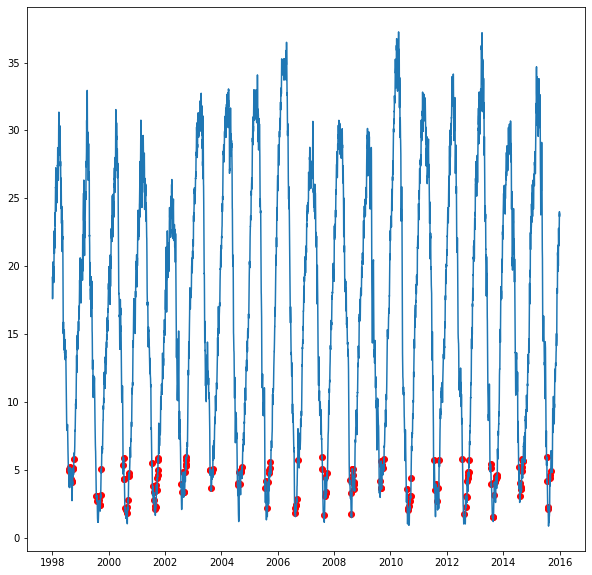

In [53]:
plt.plot(time_var['time'],time_var['variance_sst'])
plt.scatter(df_peaks['time'], df_peaks['variance_sst'],c = 'red')

The visualization is not really clear. We are going to focus on one year.

### Selection of the cyclone periods
End of the summer : from june (01/06) to the end of october (31/10)


In [54]:
cyclone_months=[i for i in range(6,11)] #define the cyclone months
df_cyclone=df_peaks.loc[df_peaks['time'].dt.month.isin(cyclone_months)] #select the cyclone months
df_cyclone['peaks']='Yes' 
df_cyclone

,time,variance_sst,diff_sst,Cyclone,peaks
212,1998-08-02,5.055515,0.071769,No,Yes
221,1998-08-11,4.940744,0.150370,Yes,Yes
229,1998-08-19,5.176624,0.263806,No,Yes
242,1998-09-01,5.082863,0.000708,No,Yes
248,1998-09-07,4.296953,0.161488,Yes,Yes
...,...,...,...,...,...
6421,2015-08-02,2.289762,0.005061,Yes,Yes
6425,2015-08-06,2.115184,0.061947,Yes,Yes
6447,2015-08-28,4.631815,0.112354,Yes,Yes
6453,2015-09-03,4.358488,0.117827,Yes,Yes


In [55]:
time_var['Cyclone']=df_cyclone['peaks']
time_var['Cyclone']=np.where(time_var['Cyclone']=='Yes', 'Yes', 'No') #indicate if a day is peak or no
time_var

,time,variance_sst,diff_sst,Cyclone
0,1998-01-02,19.170906,NaN,No
1,1998-01-03,19.047062,-0.123845,No
2,1998-01-04,18.842389,-0.204673,No
3,1998-01-05,17.598405,-1.243984,No
4,1998-01-06,17.772274,0.173869,No
...,...,...,...,...
6569,2015-12-28,23.176993,0.609652,No
6570,2015-12-29,23.893044,0.716051,No
6571,2015-12-30,24.009051,0.116008,No
6572,2015-12-31,23.654448,-0.354603,No


In [56]:
annee_var=time_var.loc[time_var['time'].dt.year.isin([2012])]


sst=px.scatter(annee_var, x='time',y='variance_sst',hover_data=['time'],color='Cyclone', title='SST variance over time')
sst.show()

Let's count the number of cyclone per year.

Text(0.5, 1.0, 'Number of cyclones per year')

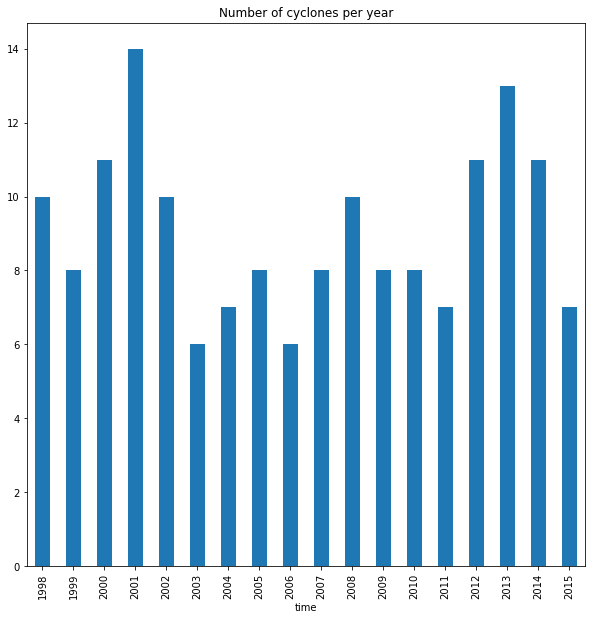

In [57]:
df_cyclone=time_var.loc[time_var['Cyclone']=='Yes']
df_group=df_cyclone.groupby(df_cyclone.time.dt.year)['Cyclone'].count()
df_group.plot(kind='bar')
plt.title('Number of cyclones per year')
xlabel('Year')